In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR, StepLR, ExponentialLR
import torchvision
import matplotlib.pyplot as plt
import dataset
from model import ResNet18YOLOv1
from loss import YOLOv1Loss
from tqdm import tqdm
from evaluate import get_bboxes, mean_average_precision

# About
This is an implementation of YOLOv1 from ***You Only Look Once: Unified, Real-Time Object Detection by Joseph Redmon, Santosh Divvala, Ross Girshick, and Ali Firhadi.*** Object detection is figuring out what objects are in an image and where they are. Another way to look at this problem is how can we write a computer program that draws bounding boxes around objects and predicts what kind of objects they are. YOLO solves this problem and does it super fast, like state of the art fast! I made slight modifications to the architecture and loss function which I'll discuss further down.

Let's talk about R-CNN, the predecessor to YOLO. It proposed regions, ran a classifier on every region, and did some post-processing to produce the final result. In simple language this translates to:
1. Lemme draw a lot of bounding boxes where I think objects are
2. Lemme figure out what are in the bounding boxes I drew
3. Ok, I drew too many bounding boxes, lemme remove most of them and keep the important ones

This is a lot of steps. What YOLO does instead is ***unified detection***. Unified detection combines the different components of object detection (where are the objects and what kind of objects are they) into one Convolutional Neural Network. You give it an image and in one swoop, it tells you exactly that.

Here's how it does it:
1. Divide the image into a SxS grid
2. Each cell in the grid predicts B bounding boxes and C class probabilities (what it thinks the object is)

We represent bounding boxes with 5 numbers: x, y, w, h, p.
- (x, y): center of the bounding box
- w: width
- h: height
- p: confidence (a measure of how confident we are that this box captures an object and matches the ground truth)

Accordingly, YOLOv1 produces a SxSx(5B+C) tensor. Each cell predicts B bounding boxes, how do we choose which one is the "true" predictor? How do we measure how good our bounding box and classification predictions are? 

We check which bounding box has the greatest overlap (IOU: Intersection Over Union) with the ground truth and choose that one as a predictor. We use this loss function to measure the "goodness" of our predictions:

![yolo loss function](https://i.stack.imgur.com/IddFu.png)

On a high level, it is the squared error between our prediction and the ground truth. Let's start training!

# Data (PASCAL VOC 2007)
PASCAL VOC Detection Dataset contains annotated images with 20 labelled classes and bounding boxes. There are 2,501 images in the training set, 2,510 images in the validation set, and 4,952 images in the test set.

In [3]:
# original dataset
pascal_voc_train = torchvision.datasets.VOCDetection(
    root="data",
    year="2007",
    image_set="train",
    download=False
)

pascal_voc_val = torchvision.datasets.VOCDetection(
    root="data",
    year="2007",
    image_set="val",
    download=False
)

pascal_voc_test = torchvision.datasets.VOCDetection(
    root="data",
    year="2007",
    image_set="test",
    download=False
)

# resize to 448x448, normalize, and convert annotations to target tensors
voc_train = dataset.PascalVOC(pascal_voc=pascal_voc_train)
voc_val = dataset.PascalVOC(pascal_voc=pascal_voc_val)
voc_test = dataset.PascalVOC(pascal_voc=pascal_voc_test)

In [4]:
# dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(voc_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(voc_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(voc_test, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 448, 448]) torch.Size([32, 7, 7, 25])


# Device

In [6]:
DEVICE = "cpu"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps")

DEVICE

device(type='cuda')

# Hyperparameters
- S: dimensions of SxS grid
- B: number of bounding boxes predicted per cell
- C: number of classes
- lambda_coord: penalty on incorrect localization loss
- lambda_noobj: penalty on incorrect noobj confidence loss

In [7]:
S = 7
B = 2
C = 20
lambda_coord = 5.0
lambda_noobj = 0.5

# Training Setup
Model, loss function, optimizer, scheduler and evaluation utils

- Model: ResNet18 convolutional layers pretrained on ImageNet with 2 feedforward layers outputting a (N x S x S x (5B + C)) tensor
- Loss: Squared Error Loss
- Adam with learning rate set to 9e-5 and weight decay (L2 Regularization) set to 0.0005

In [8]:
yolo = ResNet18YOLOv1(S=S, B=B, C=C).to(DEVICE)
yolo_loss = YOLOv1Loss(S=S, B=B, C=C, lambda_coord=lambda_coord, lambda_noobj=lambda_noobj)

In [9]:
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
LEARNING_RATE = 9e-5
EPOCHS = 135

# optimizer = torch.optim.SGD(yolo.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.Adam(yolo.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=25, gamma=1.0)

## Evaluating Loss

In [10]:
def compute_loss(model, criterion, dataloader):
    total_loss = 0
    model.eval()
    
    with torch.no_grad():
        for X, Y in dataloader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)

            pred = model(X)
            loss = criterion(pred, Y)
            total_loss += loss.item()
            break
            
    N = len(dataloader)
    # loss = total_loss / N
    loss = total_loss
    return loss

## Evaluating mAP

In [19]:
CONFIDENCE_THRESHOLD = 0.1
IOU_THRESHOLD = 0.5

In [20]:
def bboxes(model, dataloader):
    model.eval()
    pred_bboxes = []
    target_bboxes = []
    
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(DEVICE), Y.to(DEVICE)
            pred = model(X)
            
            for i in range(len(X)):
                x = pred[i]
                y = Y[i]
                
                pred_bbox = get_bboxes(x, confidence_threshold=CONFIDENCE_THRESHOLD, iou_threshold=IOU_THRESHOLD, S=S, B=B, C=C)
                target_bbox = get_bboxes(y, confidence_threshold=CONFIDENCE_THRESHOLD, iou_threshold=IOU_THRESHOLD, S=S, B=1, C=C)
                
                pred_bboxes.append(pred_bbox)
                target_bboxes.append(target_bbox)
    
    return pred_bboxes, target_bboxes

In [21]:
def compute_mAP(model, dataloader):
    pred_bboxes, target_bboxes = bboxes(model, dataloader)
    mAP = mean_average_precision(pred_bboxes, target_bboxes, iou_threshold=IOU_THRESHOLD, C=C)
    
    return mAP

# Training

In [22]:
def train(model, criterion, train_loader, val_loader, optimizer, scheduler, epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    
    N = len(train_loader)
    
    for epoch in range(epochs):
        # set to train mode
        model.train()
        total_loss = 0
        
        lr = optimizer.param_groups[0]["lr"]
        pbar = tqdm(train_loader, leave=False, desc=f"Epoch [{epoch+1}/{epochs}]: lr={lr}")
        
        for i, (X, Y) in enumerate(pbar):
            X, Y = X.to(DEVICE), Y.to(DEVICE)
            pred = model(X)
            loss = criterion(pred, Y)
            train_losses.append(loss.item())
            total_loss += loss.item()
            # val_loss = compute_loss(model, criterion, val_loader)
            # val_losses.append(val_loss)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # update progress bar
            pbar.set_postfix(batch_loss=loss.item())
        
        # update learning rate with scheduler
        scheduler.step()  
        
        # calculate metrics
        train_loss = total_loss / N
        val_loss = compute_loss(model, criterion, val_loader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # save best model
            print("=> saving model")
            torch.save(model.state_dict(), "best_model.pth")
        
        print(f"Epoch [{epoch+1}/{EPOCHS}]: Loss={train_loss}, Val Loss={val_loss}")
    
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "epochs": epochs
    }
    

In [21]:
torch.cuda.empty_cache()
train_result = train(yolo, 
      yolo_loss, 
      train_loader=train_loader, 
      val_loader=val_loader, 
      optimizer=optimizer, 
      scheduler=scheduler,
      epochs=EPOCHS
    )

=> saving model
Epoch [1/135]: Loss=7.940013281906707, Val Loss=5.026206016540527


=> saving model
Epoch [2/135]: Loss=4.594147362286532, Val Loss=4.78956413269043


=> saving model
Epoch [3/135]: Loss=3.554842070688175, Val Loss=4.598147392272949


Epoch [4/135]: Loss=2.9835089188587816, Val Loss=4.8251447677612305


=> saving model
Epoch [5/135]: Loss=2.5260675526872465, Val Loss=4.592787265777588


=> saving model
Epoch [6/135]: Loss=2.261090204685549, Val Loss=4.465628147125244


Epoch [7/135]: Loss=2.012590480756156, Val Loss=4.618456840515137


=> saving model
Epoch [8/135]: Loss=1.8069426500344579, Val Loss=4.456894397735596


Epoch [9/135]: Loss=1.6466763494889947, Val Loss=4.5593719482421875


=> saving model
Epoch [10/135]: Loss=1.5231370427940465, Val Loss=4.366403579711914


Epoch [11/135]: Loss=1.4199177675609347, Val Loss=4.41232967376709


Epoch [12/135]: Loss=1.3734375034706503, Val Loss=4.458100318908691


=> saving model
Epoch [13/135]: Loss=1.2798045262505737, Val Loss=4.333035945892334


=> saving model
Epoch [14/135]: Loss=1.2321847631961484, Val Loss=4.313815116882324


=> saving model
Epoch [15/135]: Loss=1.1732996324949627, Val Loss=4.284572601318359


Epoch [16/135]: Loss=1.1329616293122498, Val Loss=4.3228607177734375


Epoch [17/135]: Loss=1.1127399960650672, Val Loss=4.492802619934082


=> saving model
Epoch [18/135]: Loss=1.0634630201738091, Val Loss=4.196168899536133


=> saving model
Epoch [19/135]: Loss=1.024826990652688, Val Loss=4.194153785705566


Epoch [20/135]: Loss=0.9865334758275672, Val Loss=4.258266448974609


Epoch [21/135]: Loss=0.9666546145571938, Val Loss=4.4595417976379395


Epoch [22/135]: Loss=0.942907033087332, Val Loss=4.237427711486816


Epoch [23/135]: Loss=0.9164031638374811, Val Loss=4.249871730804443


Epoch [24/135]: Loss=0.8833975022352194, Val Loss=4.339118957519531


Epoch [25/135]: Loss=0.8831164331375798, Val Loss=4.3453216552734375


Epoch [26/135]: Loss=0.855274810066706, Val Loss=4.256765365600586


Epoch [27/135]: Loss=0.8300442318373089, Val Loss=4.243349075317383


Epoch [28/135]: Loss=0.8037171929697448, Val Loss=4.272526264190674


Epoch [29/135]: Loss=0.8138093073156816, Val Loss=4.302827835083008


Epoch [30/135]: Loss=0.8022706150254116, Val Loss=4.26365327835083


=> saving model
Epoch [31/135]: Loss=0.776253065730952, Val Loss=4.080413818359375


Epoch [32/135]: Loss=0.7465774311295038, Val Loss=4.202256679534912


Epoch [33/135]: Loss=0.7244415558591674, Val Loss=4.179912567138672


Epoch [34/135]: Loss=0.7114514191693897, Val Loss=4.087169647216797


Epoch [35/135]: Loss=0.7088007493109643, Val Loss=4.175232410430908


Epoch [36/135]: Loss=0.695773634729506, Val Loss=4.206765651702881


Epoch [37/135]: Loss=0.6825305396997476, Val Loss=4.346329212188721


Epoch [38/135]: Loss=0.6935851215561734, Val Loss=4.210646629333496


Epoch [39/135]: Loss=0.6745897324024877, Val Loss=4.1079020500183105


Epoch [40/135]: Loss=0.65778966870489, Val Loss=4.261788368225098


Epoch [41/135]: Loss=0.6572806393798394, Val Loss=4.183696746826172


Epoch [42/135]: Loss=0.6548361914067329, Val Loss=4.292511463165283


Epoch [43/135]: Loss=0.6363626216785817, Val Loss=4.249345779418945


Epoch [44/135]: Loss=0.6226611608945871, Val Loss=4.304522514343262


Epoch [45/135]: Loss=0.6151784771605383, Val Loss=4.25986385345459


Epoch [46/135]: Loss=0.6118868106528174, Val Loss=4.33390998840332


Epoch [47/135]: Loss=0.6030927402309224, Val Loss=4.255785942077637


Epoch [48/135]: Loss=0.600020611587959, Val Loss=4.31973934173584


Epoch [49/135]: Loss=0.6149683779553522, Val Loss=4.196076393127441


Epoch [50/135]: Loss=0.6052868313427213, Val Loss=4.2704949378967285


Epoch [51/135]: Loss=0.5872491488728342, Val Loss=4.235753059387207


Epoch [52/135]: Loss=0.5770197540898866, Val Loss=4.244563579559326


Epoch [53/135]: Loss=0.5735842698737036, Val Loss=4.197484970092773


Epoch [54/135]: Loss=0.5715851859201359, Val Loss=4.3429484367370605


Epoch [55/135]: Loss=0.5563559641566458, Val Loss=4.275839805603027


Epoch [56/135]: Loss=0.5647901066496402, Val Loss=4.2437944412231445


Epoch [57/135]: Loss=0.565709715402579, Val Loss=4.366217613220215


Epoch [58/135]: Loss=0.552877024004731, Val Loss=4.279318809509277


Epoch [59/135]: Loss=0.5392068326473236, Val Loss=4.185030937194824


Epoch [60/135]: Loss=0.5423828567130656, Val Loss=4.179696083068848


Epoch [61/135]: Loss=0.5279618735554852, Val Loss=4.312691688537598


Epoch [62/135]: Loss=0.5259616544729546, Val Loss=4.246252059936523


=> saving model
Epoch [63/135]: Loss=0.52939005893997, Val Loss=4.0528998374938965


Epoch [64/135]: Loss=0.5214297514927538, Val Loss=4.210159778594971


Epoch [65/135]: Loss=0.5266462541833709, Val Loss=4.161397933959961


Epoch [66/135]: Loss=0.5335149070884608, Val Loss=4.314488410949707


Epoch [67/135]: Loss=0.5392483129531522, Val Loss=4.154533386230469


Epoch [68/135]: Loss=0.5275381135789654, Val Loss=4.133731365203857


Epoch [69/135]: Loss=0.5152667425101316, Val Loss=4.083788871765137


=> saving model
Epoch [70/135]: Loss=0.506470200004457, Val Loss=4.0491766929626465


Epoch [71/135]: Loss=0.5112701729883121, Val Loss=4.086236476898193


Epoch [72/135]: Loss=0.5078855492646182, Val Loss=4.203993320465088


Epoch [73/135]: Loss=0.5065457383288613, Val Loss=4.074007034301758


Epoch [74/135]: Loss=0.5068171869350385, Val Loss=4.314756870269775


Epoch [75/135]: Loss=0.49896310213245926, Val Loss=4.313651084899902


Epoch [76/135]: Loss=0.48855482117284704, Val Loss=4.280666351318359


Epoch [77/135]: Loss=0.48534593702871587, Val Loss=4.180500030517578


Epoch [78/135]: Loss=0.48120727248584166, Val Loss=4.186089515686035


Epoch [79/135]: Loss=0.47822241730327847, Val Loss=4.403136253356934


Epoch [80/135]: Loss=0.48316462922699843, Val Loss=4.17837381362915


Epoch [81/135]: Loss=0.48306812176221536, Val Loss=4.140645980834961


Epoch [82/135]: Loss=0.48077013598212714, Val Loss=4.185340881347656


Epoch [83/135]: Loss=0.47055756668501264, Val Loss=4.303949356079102


Epoch [84/135]: Loss=0.4708445753100552, Val Loss=4.123803615570068


Epoch [85/135]: Loss=0.4579077512025833, Val Loss=4.08115291595459


Epoch [86/135]: Loss=0.45407533645629883, Val Loss=4.266786575317383


Epoch [87/135]: Loss=0.4694032386133942, Val Loss=4.268200397491455


Epoch [88/135]: Loss=0.4851576795306387, Val Loss=4.342455863952637


Epoch [89/135]: Loss=0.4862089570187315, Val Loss=4.31969690322876


Epoch [90/135]: Loss=0.473014558040643, Val Loss=4.232754230499268


Epoch [91/135]: Loss=0.4720598974182636, Val Loss=4.0991597175598145


Epoch [92/135]: Loss=0.4812116241907772, Val Loss=4.14471435546875


Epoch [93/135]: Loss=0.47534057950671715, Val Loss=4.163241386413574


Epoch [94/135]: Loss=0.46901102873343453, Val Loss=4.196793556213379


Epoch [95/135]: Loss=0.4580243082740639, Val Loss=4.2256999015808105


Epoch [96/135]: Loss=0.4618628228767009, Val Loss=4.074158668518066


Epoch [97/135]: Loss=0.4501780305482164, Val Loss=4.145842552185059


Epoch [98/135]: Loss=0.4380141504203217, Val Loss=4.1442766189575195


Epoch [99/135]: Loss=0.4401241982284981, Val Loss=4.344023704528809


Epoch [100/135]: Loss=0.4468376059320909, Val Loss=4.171147346496582


Epoch [101/135]: Loss=0.4477661346332936, Val Loss=4.195188045501709


Epoch [102/135]: Loss=0.45149930123286913, Val Loss=4.104755401611328


Epoch [103/135]: Loss=0.44331647021861015, Val Loss=4.092508316040039


Epoch [104/135]: Loss=0.4430308602278746, Val Loss=4.236269474029541


Epoch [105/135]: Loss=0.4442310917981063, Val Loss=4.2530741691589355


Epoch [106/135]: Loss=0.43625865763501276, Val Loss=4.142955780029297


Epoch [107/135]: Loss=0.43964590679241133, Val Loss=4.183916091918945


Epoch [108/135]: Loss=0.43077007086971136, Val Loss=4.21732234954834


Epoch [109/135]: Loss=0.43610596090932435, Val Loss=4.230308532714844


Epoch [110/135]: Loss=0.4365325292831735, Val Loss=4.342510223388672


Epoch [111/135]: Loss=0.427281968201263, Val Loss=4.19342041015625


Epoch [112/135]: Loss=0.4377603657260726, Val Loss=4.204184055328369


Epoch [113/135]: Loss=0.4345948922483227, Val Loss=4.264296531677246


Epoch [114/135]: Loss=0.43493499031549765, Val Loss=4.11440372467041


Epoch [115/135]: Loss=0.44922227006924303, Val Loss=4.108255386352539


Epoch [116/135]: Loss=0.4192839170558543, Val Loss=4.224674224853516


Epoch [117/135]: Loss=0.41422059754782087, Val Loss=4.242926120758057


Epoch [118/135]: Loss=0.40832184311709824, Val Loss=4.138825416564941


Epoch [119/135]: Loss=0.3996054847029191, Val Loss=4.17027473449707


Epoch [120/135]: Loss=0.4051804853768288, Val Loss=4.176767349243164


Epoch [121/135]: Loss=0.4089750687155542, Val Loss=4.097171783447266


Epoch [122/135]: Loss=0.40383617485625833, Val Loss=4.251833915710449


Epoch [123/135]: Loss=0.401775407074373, Val Loss=4.157722473144531


Epoch [124/135]: Loss=0.39707242763495143, Val Loss=4.109591484069824


Epoch [125/135]: Loss=0.404986285333392, Val Loss=4.1396894454956055


Epoch [126/135]: Loss=0.395341441223893, Val Loss=4.22751522064209


Epoch [127/135]: Loss=0.39841118134275266, Val Loss=4.204306602478027


Epoch [128/135]: Loss=0.39655957286116444, Val Loss=4.113130569458008


Epoch [129/135]: Loss=0.4013288503960718, Val Loss=4.244327545166016


Epoch [130/135]: Loss=0.403921864266637, Val Loss=4.2583136558532715


Epoch [131/135]: Loss=0.40103187232832366, Val Loss=4.27334451675415


=> saving model
Epoch [132/135]: Loss=0.3967030842470217, Val Loss=4.002902984619141


Epoch [133/135]: Loss=0.40338620486893234, Val Loss=4.1046366691589355


Epoch [134/135]: Loss=0.3995283685530288, Val Loss=4.1901092529296875


Epoch [135/135]: Loss=0.39568727246568175, Val Loss=4.173301696777344


NameError: name 'pre_epochs' is not defined

# Evaluate

In [23]:
yolo.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
yolo.eval()

ResNet18YOLOv1(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-

In [24]:
compute_mAP(yolo, train_loader)

0.7818589270114898

In [25]:
compute_mAP(yolo, val_loader)

0.16692779567092658

In [26]:
compute_mAP(yolo, test_loader)

0.17914867820218205

## Visualizing Bounding Box

tensor([[0.7492, 0.0882, 0.2185, 0.9252, 0.8492, 0.9818, 6.0000]],
       device='cuda:0', grad_fn=<CatBackward0>)
cateogry: car


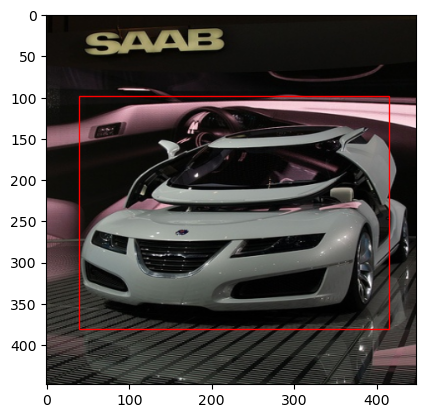

In [37]:
import matplotlib.patches as patches
i = 5

X, Y = voc_val[i]
X = X.unsqueeze(0).to(DEVICE)
pred = yolo(X)[0]
bboxes = get_bboxes(pred, confidence_threshold=0.25)
print(bboxes)

fig, ax = plt.subplots()

for bbox in bboxes:
    confidence = bbox[0]
    x1y1x2y2 = bbox[1:5]
    probability = bbox[5]
    class_idx = bbox[6]
    
    category = dataset.PascalVOC.categories_list[int(class_idx)]
    print(f"cateogry: {category}")
    
    x1y1x2y2 = x1y1x2y2.cpu().detach().numpy() * 448
    x1 = x1y1x2y2[0]
    y1 = x1y1x2y2[1]
    x2 = x1y1x2y2[2]
    y2 = x1y1x2y2[3]
    
    width = x2 - x1
    height = y2 - y1
    
    rect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Resize((448, 448))])
img = transform(pascal_voc_val[i][0]).permute((1, 2, 0))
ax.imshow(img)